# Bird Classification CNN

In [1]:
# Imports

import os
import shutil

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from skimage.io import imread

from tqdm import tqdm

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.utils import shuffle

import PIL
from PIL import Image

import tensorflow as tf
import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.losses import SparseCategoricalCrossentropy
from keras.layers import Dense, Conv2D, MaxPool2D, MaxPooling2D, Flatten

In [2]:
# Data File Paths

training_data_directory = r"C:\Users\Niocu\OneDrive\Data Science\ds-machine-learning-project-4-main\data\train"
testing_data_directory = r"C:\Users\Niocu\OneDrive\Data Science\ds-machine-learning-project-4-main\data\test"
validation_data_directory = r"C:\Users\Niocu\OneDrive\Data Science\ds-machine-learning-project-4-main\data\valid"

In [3]:
# Find 15 species with most images

# Initiate counts dictionary
species_counts = {}

# Iterate over subdirectories
for species in os.listdir(training_data_directory):
    species_dir = os.path.join(training_data_directory, species)
    if os.path.isdir(species_dir):
        species_counts[species] = len(os.listdir(species_dir))

# Sort dictionary by counts
sorted_species_counts = sorted(species_counts.items(), key=lambda x: x[1], reverse=True)

# Get top 15 species
top_15_species = sorted_species_counts[:15]

# Print top 15 species
for species, count in top_15_species:
    print(f"{species}: {count} images")


RUFOUS TREPE: 263 images
HOUSE FINCH: 248 images
D-ARNAUDS BARBET: 233 images
OVENBIRD: 233 images
ASIAN GREEN BEE EATER: 220 images
SWINHOES PHEASANT: 216 images
WOOD DUCK: 214 images
CASPIAN TERN: 213 images
RED BILLED TROPICBIRD: 212 images
WOOD THRUSH: 211 images
FRILL BACK PIGEON: 209 images
MERLIN: 209 images
PYRRHULOXIA: 209 images
MILITARY MACAW: 208 images
ORNATE HAWK EAGLE: 208 images


In [4]:
# Delete unused species data

# Used species
bird_species = [
    "RUFOUS TREPE",
    "HOUSE FINCH",
    "D-ARNAUDS BARBET",
    "OVENBIRD",
    "ASIAN GREEN BEE EATER",
    "SWINHOES PHEASANT",
    "WOOD DUCK",
    "CASPIAN TERN",
    "RED BILLED TROPICBIRD",
    "WOOD THRUSH",
    "FRILL BACK PIGEON",
    "MERLIN",
    "PYRRHULOXIA",
    "MILITARY MACAW",
    "ORNATE HAWK EAGLE"
]

# Base directory path
base_dir = r"C:\Users\Niocu\OneDrive\Data Science\ds-machine-learning-project-4-main\data"

# Iterate over the test, train, and valid folders
for folder in ["test", "train", "valid"]:
    folder_path = os.path.join(base_dir, folder)
    # Iterate over all directories in the current folder
    for directory in os.listdir(folder_path):
        # Check if the directory is not in the specified bird species list and delete if not
        if directory not in bird_species:
            path = os.path.join(folder_path, directory)
            if os.path.isdir(path):
                print(f"Deleting directory: {path}")
                # Delete all files inside the directory
                shutil.rmtree(path)

In [5]:
# Shuffle, randomize, and normalize data

# Define data generators
num_classes = 15
batch_size = 64

train_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalize pixel values
    rotation_range=20,  # Rotate
    width_shift_range=0.2,  # Shift images horizontally
    height_shift_range=0.2,  # Shift images vertically
    shear_range=0.2,  # Distort images (shear)
    zoom_range=0.2,  # Zoom images
    horizontal_flip=True,  # Flip images
    fill_mode='nearest'  # Fill in new pixels
)

test_datagen = ImageDataGenerator(rescale=1./255)

# Define data iterators
train_generator = train_datagen.flow_from_directory(
    training_data_directory,
    target_size=(150, 150),  # Resize images to 150x150 pixels
    batch_size=batch_size,
    class_mode='sparse'
)

validation_generator = test_datagen.flow_from_directory(
    validation_data_directory,
    target_size=(150, 150),
    batch_size=batch_size,
    class_mode='sparse'
)

# Define test data iterator
test_generator = test_datagen.flow_from_directory(
    testing_data_directory,
    target_size=(150, 150),
    batch_size=batch_size,
    class_mode='sparse'
)

Found 3306 images belonging to 15 classes.
Found 75 images belonging to 15 classes.
Found 75 images belonging to 15 classes.


In [91]:
# Model 1

# Simplest model possible for testing other code
# Input shape == images are 150 x 150 pixels, RGB = 3
# 128 neurons = aribtrary number
# Softmax on output layer to convert raw output scores into probabilities by class

num_classes = 15

model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(150, 150, 3)),  # Flatten input images
    tf.keras.layers.Dense(128, activation='relu'), 
    tf.keras.layers.Dense(num_classes, activation='softmax')  # Output
])

# Result - Terrible accuracy, helped finish evluation and prediction code

In [62]:
# Model 2

# Used Conv2D layers to extract most important features
    # Increasing amount of neurons to perform heirarchical classification
# Added MaxPooling2D layers to reduce spatial dimensions
# Added Flatten layer to allow dense layer to receive 1D input
# Kept penultimate Dense layer to reduce dimensionality and represent compact information

num_classes = 15

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

In [63]:
# Model 3

# Added BatchNormalization layers to stabilize training process
# Changed neurons on penultimate layer match num_classes

num_classes = 15

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)), 
    tf.keras.layers.BatchNormalization(), 
    tf.keras.layers.MaxPooling2D(2, 2), 
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'), 
    tf.keras.layers.BatchNormalization(), 
    tf.keras.layers.MaxPooling2D(2, 2), 
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),  
    tf.keras.layers.BatchNormalization(), 
    tf.keras.layers.MaxPooling2D(2, 2), 
    tf.keras.layers.Flatten(), 
    tf.keras.layers.Dense(num_classes, activation='relu'), 
    tf.keras.layers.Dense(num_classes, activation='softmax') 
])

In [64]:
# Model 4

# Add dropout layer to prevent overfitting - better initial test results, so added more layers:
    # Add new step to heirarchy (256 neurons)
    # Add GlobalAveragePooling layer to end for dimensionality reduction

dropout_rate = 0.5

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),  
    tf.keras.layers.BatchNormalization(),  
    tf.keras.layers.MaxPooling2D(2, 2), 
    tf.keras.layers.Dropout(dropout_rate),
    
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),  
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(dropout_rate),
    
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),  
    tf.keras.layers.BatchNormalization(),  
    tf.keras.layers.MaxPooling2D(2, 2), 
    tf.keras.layers.Dropout(dropout_rate),

    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(256, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(256, (3, 3), activation='relu'),
    tf.keras.layers.GlobalAveragePooling2D(),
    
    tf.keras.layers.Flatten(),  
    tf.keras.layers.Dense(num_classes, activation='relu'), 
    tf.keras.layers.Dropout(dropout_rate),
    tf.keras.layers.Dense(num_classes, activation='softmax') 
])

In [22]:
# Model 5

# Testing with more or less layers seemed to return better results with an extra set of layers (256 neurons)
# Also switched to sparse categorical crossentropy as it should work better with a large number of integer labels

dropout_rate = 0.5

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),  
    tf.keras.layers.BatchNormalization(),  
    tf.keras.layers.MaxPooling2D(2, 2), 
    tf.keras.layers.Dropout(dropout_rate),
    
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),  
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(dropout_rate),
    
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),  
    tf.keras.layers.BatchNormalization(),  
    tf.keras.layers.MaxPooling2D(2, 2), 
    tf.keras.layers.Dropout(dropout_rate),

    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(256, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(256, (3, 3), activation='relu'),
    tf.keras.layers.GlobalAveragePooling2D(),
    
    tf.keras.layers.Flatten(),  
    tf.keras.layers.Dense(256, activation='relu'), 
    tf.keras.layers.Dropout(dropout_rate),
    tf.keras.layers.Dense(num_classes, activation='softmax') 
])

In [23]:
# Print model summary
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_15 (Conv2D)              │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 148, 148, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 72, 72, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 34, 34, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 17, 17, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 15, 15, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 7, 7, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 7, 7, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 5, 5, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 15)             │         3,85

 Total params: 1,050,575 (4.01 MB)

 Trainable params: 1,049,359 (4.00 MB)

 Non-trainable params: 1,216 (4.75 KB)

In [24]:
# Compile model

# adam optimizer for simplicity (good results with default hyperparameters)

# categorical crossentropy loss function for good results with many one-hot encoded classes
    # keras automatically uses one-hot encoded
# switched to sparse categorical cross entropy due to better performance with large number of integer labels

# accuracy as metric to reflect correctly classified instances

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [25]:
# Train model

# 5 epochs, 16, 32, 64 batch size = ran out of data

history = model.fit(
    train_generator,
    epochs=23,
    validation_data=validation_generator,
)

Epoch 1/23
52/52 ━━━━━━━━━━━━━━━━━━━━ 33s 566ms/step - accuracy: 0.1787 - loss: 2.6038 - val_accuracy: 0.0667 - val_loss: 2.8155
Epoch 2/23
52/52 ━━━━━━━━━━━━━━━━━━━━ 31s 567ms/step - accuracy: 0.2874 - loss: 2.1493 - val_accuracy: 0.0667 - val_loss: 3.4533
Epoch 3/23
52/52 ━━━━━━━━━━━━━━━━━━━━ 31s 561ms/step - accuracy: 0.3827 - loss: 1.9495 - val_accuracy: 0.0933 - val_loss: 3.7146
Epoch 4/23
52/52 ━━━━━━━━━━━━━━━━━━━━ 31s 574ms/step - accuracy: 0.4304 - loss: 1.7493 - val_accuracy: 0.0667 - val_loss: 4.0200
Epoch 5/23
52/52 ━━━━━━━━━━━━━━━━━━━━ 31s 574ms/step - accuracy: 0.4691 - loss: 1.6300 - val_accuracy: 0.1200 - val_loss: 4.1631
Epoch 6/23
52/52 ━━━━━━━━━━━━━━━━━━━━ 31s 577ms/step - accuracy: 0.5295 - loss: 1.5186 - val_accuracy: 0.1333 - val_loss: 4.8340
Epoch 7/23
52/52 ━━━━━━━━━━━━━━━━━━━━ 31s 572ms/step - accuracy: 0.5431 - loss: 1.4050 - val_accuracy: 0.3467 - val_loss: 2.5296
Epoch 8/23
52/52 ━━━━━━━━━━━━━━━━━━━━ 32s 579ms/step - accuracy: 0.5596 - loss: 1.3313 - val_accu

In [26]:
# Save trained model
model.save("model_5_15speciesAdjustedNeurons.h5")

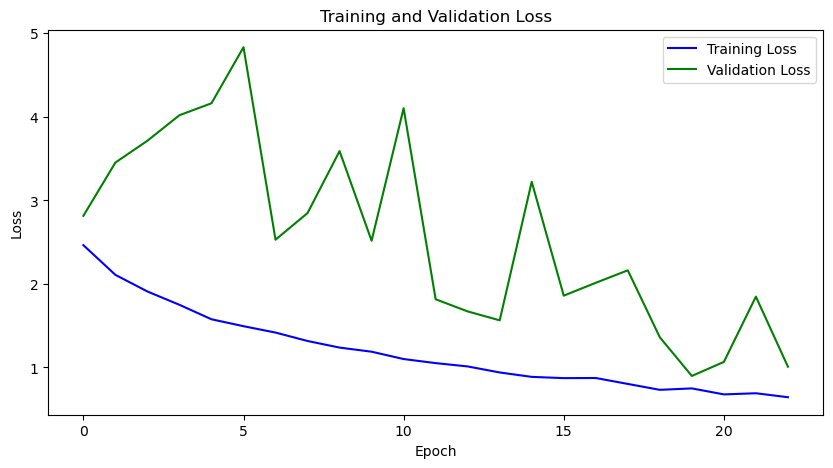

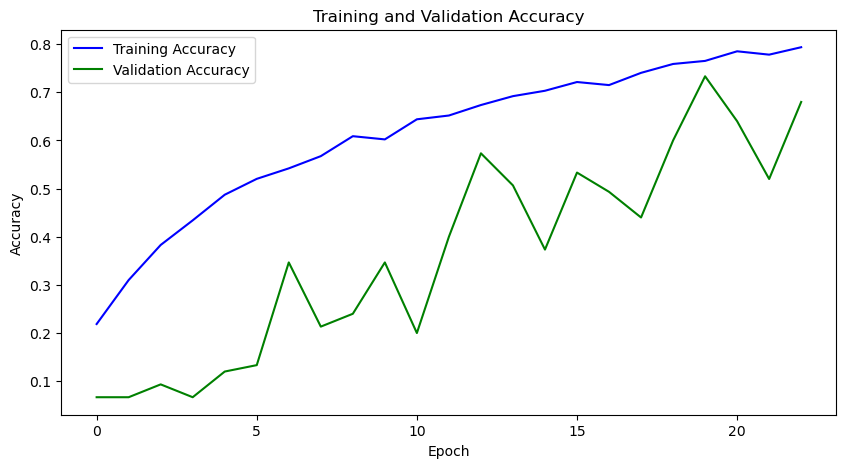

In [27]:
# Plot Training Accuracy and Loss

# Get history
train_loss = history.history['loss']
train_accuracy = history.history['accuracy']
val_loss = history.history['val_loss']
val_accuracy = history.history['val_accuracy']

# Plot loss
plt.figure(figsize=(10, 5))
plt.plot(train_loss, label='Training Loss', color='blue')
plt.plot(val_loss, label='Validation Loss', color='green')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_accuracy, label='Training Accuracy', color='blue')
plt.plot(val_accuracy, label='Validation Accuracy', color='green')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [28]:
# Evaluate model on test data
test_loss, test_acc = model.evaluate(test_generator)
print('Test accuracy:', test_acc)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7990 - loss: 0.8064 
Test accuracy: 0.800000011920929
